# Kaplan-Meier model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.datasets import load_waltons

# Load the example lung cancer dataset
data = load_waltons()
print(data.head())


      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


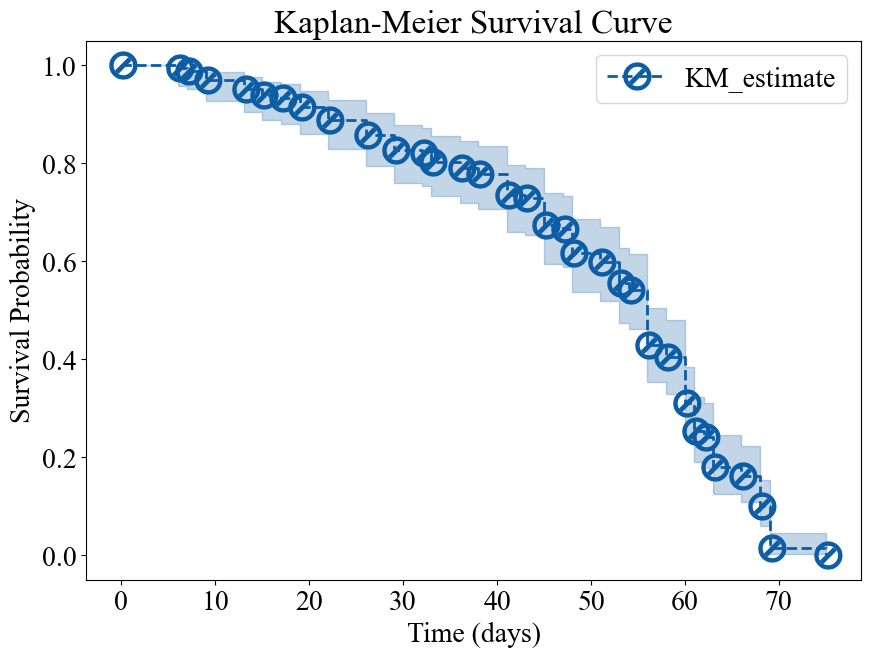

In [3]:
kmf = KaplanMeierFitter()
kmf.fit(data['T'], event_observed=data['E'])
plt.figure(figsize=(10, 7))
kmf.plot()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")

# Cox proportional hazard model

Text(0, 0.5, 'Coefficient')

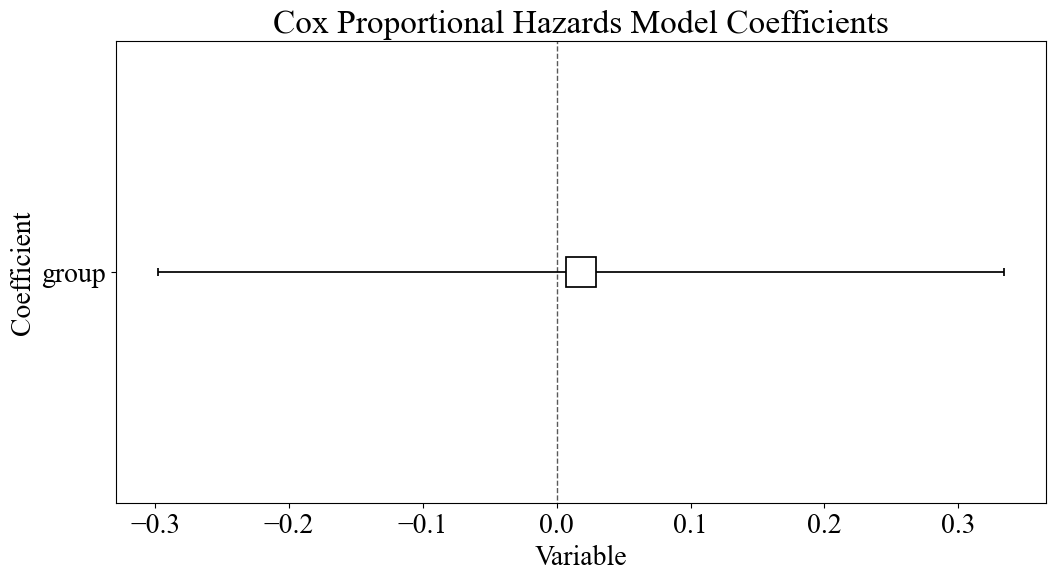

In [7]:
np.random.seed(42)
data['group'] = np.random.randint(0, 2, size=len(data))
cph = CoxPHFitter()
cph.fit(data, duration_col='T', event_col='E')
cph.plot()
plt.title("Cox Proportional Hazards Model Coefficients")
plt.xlabel("Variable")
plt.ylabel("Coefficient")

In [9]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
group,0.018112,1.018277,0.161167,-0.29777,0.333994,0.742472,1.396535,0.0,0.112381,0.910521,0.135236


Text(0, 0.5, 'Survival function')

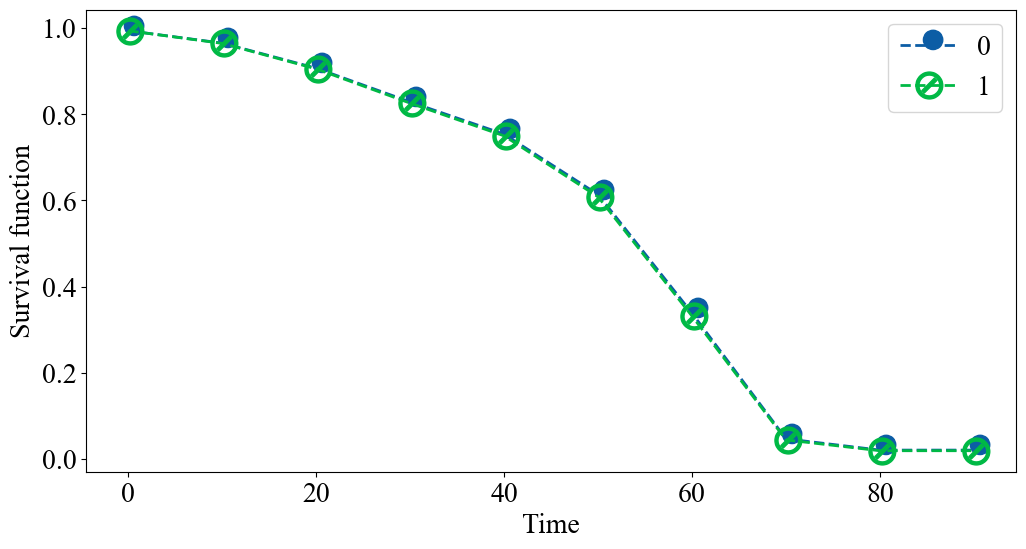

In [13]:
new_patients = pd.DataFrame({"group": [0, 1]})
time_points = np.arange(0, 100, 10)
predicted_survival = cph.predict_survival_function(new_patients, times=time_points)
predicted_survival.plot()
plt.xlabel("Time")
plt.ylabel("Survival function")

# XGBoost

In [282]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.datasets import load_rossi
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

# Load the dataset
rossi = load_rossi()
X = rossi.drop(columns=['arrest', 'week'])
y = rossi[['week', 'arrest']]

In [283]:
def get_upper_limit(y_train):
    return y_train.apply(
        lambda row: row["week"] if row["arrest"] else np.inf,
        axis=1
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(
    X_train, label=y_train['week'],
    label_lower_bound=y_train['week'],
    label_upper_bound=get_upper_limit(y_train)
)
dtest = xgb.DMatrix(
    X_test, label=y_test['week'],
    label_lower_bound=y_test['week'],
    label_upper_bound=get_upper_limit(y_test),
)

In [284]:
params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.5,
    'objective': 'survival:aft',
    'seed': 42,
    'eval_metric': 'aft-nloglik',
}
num_rounds = 1000
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=10,
)

[0]	train-aft-nloglik:11.85221	test-aft-nloglik:11.83264
[10]	train-aft-nloglik:5.48819	test-aft-nloglik:5.51678
[20]	train-aft-nloglik:3.09228	test-aft-nloglik:3.17688
[30]	train-aft-nloglik:2.13754	test-aft-nloglik:2.27603
[40]	train-aft-nloglik:1.73375	test-aft-nloglik:1.93760
[50]	train-aft-nloglik:1.53548	test-aft-nloglik:1.81802
[60]	train-aft-nloglik:1.42725	test-aft-nloglik:1.78291
[70]	train-aft-nloglik:1.36071	test-aft-nloglik:1.77727
[74]	train-aft-nloglik:1.34096	test-aft-nloglik:1.78604


In [290]:
y_pred = model.predict(dtest)
c_index = concordance_index(
    event_times=y_test['week'],
    predicted_scores=y_pred,
    event_observed=y_test['arrest']
)
print(f"Concordance index: {c_index:.4f}")

Concordance index: 0.6812


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

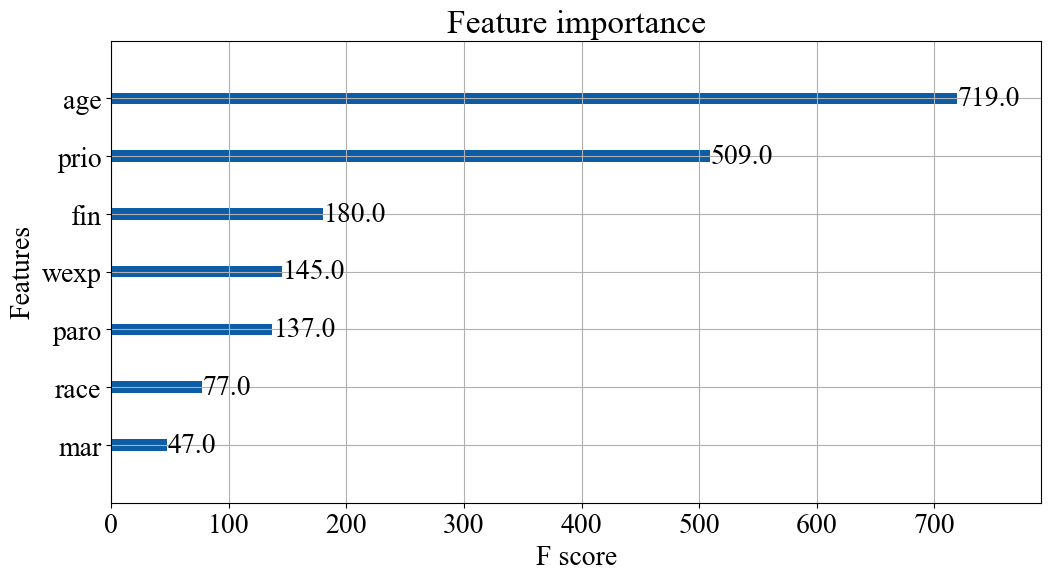

In [292]:
from xgboost import plot_importance
plot_importance(model.get_score())

In [311]:
def compute_survival_probabilities(model, data, times):
    survival_probabilities = []
    for t in times:
        d = xgb.DMatrix(
            data, label=np.full(data.shape[0], t),
        )
        survival_probabilities.append(1 - (t < model.predict(d, output_margin=True)))
    return np.array(survival_probabilities).T

times = np.arange(1, 100)
survival_probabilities = compute_survival_probabilities(model, X_test, times)


<AxesSubplot: >

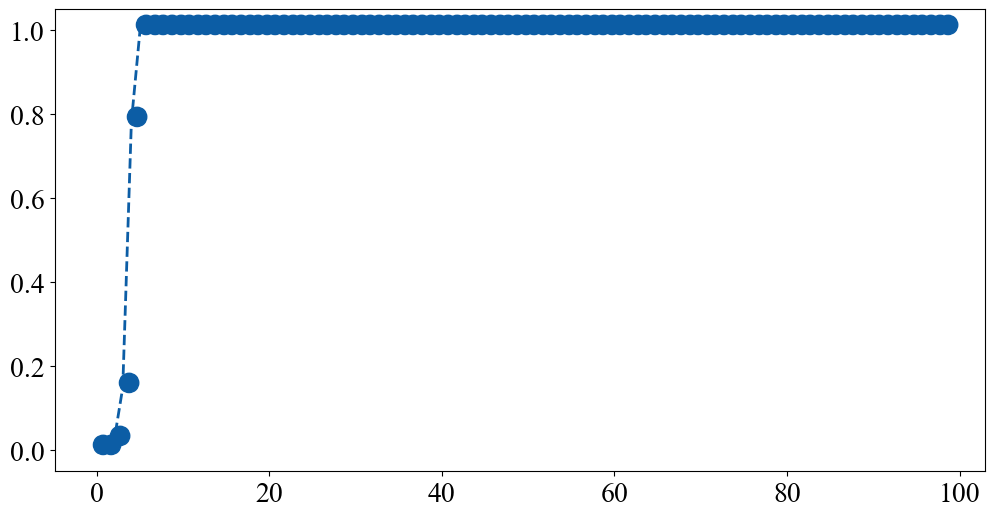

In [323]:
pd.DataFrame(survival_probabilities).mean().plot()

In [298]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
aft.fit(rossi, duration_col='week', event_col='arrest', ancillary=True)
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
   number of observations = 432
number of events observed = 114
           log-likelihood = -669.40
         time fit was run = 2023-04-09 21:30:34 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ age         0.10       1.10       0.03             0.04             0.16                 1.04                 1.17
        fin         0.24       1.28       0.15            -0.06             0.55                 0.95                 1.73
        mar         0.26       1.30       0.30            -0.33             0.85                 0.72                 2.35
        paro        0.09       1.10       0.15            -0.21             0.39                 0.81                 1.48
        prio       -0.08       0.92       0.02            -0.12            -0.04                 0.89                 0.96
        race        0.07       1.07       0.19            -0.30             0.44                 0.74                 1.55
        wexp       -0.34       0.71       0.15            -0.64            -0.04                 0.53                 0.96
        Intercept   2.68      14.65       0.60             1.51             3.85                 4.55                47.22
rho_    age        -0.05       0.95       0.02            -0.08            -0.02                 0.93                 0.98
        fin        -0.01       0.99       0.15            -0.31             0.29                 0.73                 1.33
        mar         0.10       1.10       0.27            -0.44             0.63                 0.65                 1.87
        paro        0.02       1.02       0.16            -0.29             0.33                 0.75                 1.39
        prio        0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
        race       -0.46       0.63       0.25            -0.95             0.04                 0.39                 1.04
        wexp        0.56       1.74       0.17             0.23             0.88                 1.26                 2.42
        Intercept   1.48       4.41       0.41             0.68             2.29                 1.97                 9.89

                    cmp to     z      p   -log2(p)
param   covariate                                 
lambda_ age           0.00  3.43 <0.005      10.69
        fin           0.00  1.60   0.11       3.18
        mar           0.00  0.86   0.39       1.35
        paro          0.00  0.61   0.54       0.88
        prio          0.00 -4.24 <0.005      15.46
        race          0.00  0.36   0.72       0.48
        wexp          0.00 -2.22   0.03       5.26
        Intercept     0.00  4.50 <0.005      17.14
rho_    age           0.00 -3.10 <0.005       9.01
        fin           0.00 -0.09   0.92       0.11
        mar           0.00  0.36   0.72       0.47
        paro          0.00  0.12   0.90       0.15
        prio          0.00  1.44   0.15       2.73
        race          0.00 -1.79   0.07       3.77
        wexp          0.00  3.32 <0.005      10.13
        Intercept     0.00  3.60 <0.005      11.62
---
Concordance = 0.63
AIC = 1370.80
log-likelihood ratio test = 54.45 on 14 df
-log2(p) of ll-ratio test = 19.83